In [13]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [14]:
data_set = './all_data/'

# Define data augmentation transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the expected size for ResNet18
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet's mean and std
])



# Load dataset
# # Original data
dataset = datasets.ImageFolder(root=data_set, transform=transform)
# # Preprocess_data
dataset = datasets.ImageFolder(root=data_set, transform=transform)

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

# Load pretrained ResNet18 model
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, len(dataset.classes))  # Modify the final fully connected layer for classification
model.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(num_ftrs, len(dataset.classes)))

In [15]:
# Move model to GPU for acceleration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


In [16]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.001)

# Train the model
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    model.train()
    for epoch in range(num_epochs):
        train_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}, Train')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({'loss': train_loss / len(progress_bar), 'accuracy': 100 * correct / total})

        train_accuracy = 100 * correct / total
        val_loss, val_accuracy = evaluate_model(model, criterion, val_loader)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss)
        torch.save(model.state_dict(), "resnet50_2_epoch_"+str(epoch)+".pth")

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_accuracies, val_accuracies, train_losses, val_losses

def evaluate_model(model, criterion, dataloader):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [17]:
# Train the model and plot accuracies and losses
train_accuracies, val_accuracies, train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5)

Epoch 1/5, Train: 100%|██████████| 1153/1153 [20:36<00:00,  1.07s/it, loss=1.71, accuracy=57.4]


Epoch [1/5], Train Loss: 1.7125, Train Accuracy: 57.42%, Val Loss: 0.6988, Val Accuracy: 80.07%


Epoch 2/5, Train: 100%|██████████| 1153/1153 [19:23<00:00,  1.01s/it, loss=0.543, accuracy=82.3]


Epoch [2/5], Train Loss: 0.5431, Train Accuracy: 82.30%, Val Loss: 0.5050, Val Accuracy: 83.59%


Epoch 3/5, Train: 100%|██████████| 1153/1153 [19:38<00:00,  1.02s/it, loss=0.394, accuracy=87.2]


Epoch [3/5], Train Loss: 0.3940, Train Accuracy: 87.18%, Val Loss: 0.4699, Val Accuracy: 84.70%


Epoch 4/5, Train: 100%|██████████| 1153/1153 [19:39<00:00,  1.02s/it, loss=0.316, accuracy=89.6]


Epoch [4/5], Train Loss: 0.3156, Train Accuracy: 89.61%, Val Loss: 0.4688, Val Accuracy: 85.33%


Epoch 5/5, Train: 100%|██████████| 1153/1153 [19:44<00:00,  1.03s/it, loss=0.259, accuracy=91.4]


Epoch [5/5], Train Loss: 0.2588, Train Accuracy: 91.40%, Val Loss: 0.4366, Val Accuracy: 86.25%


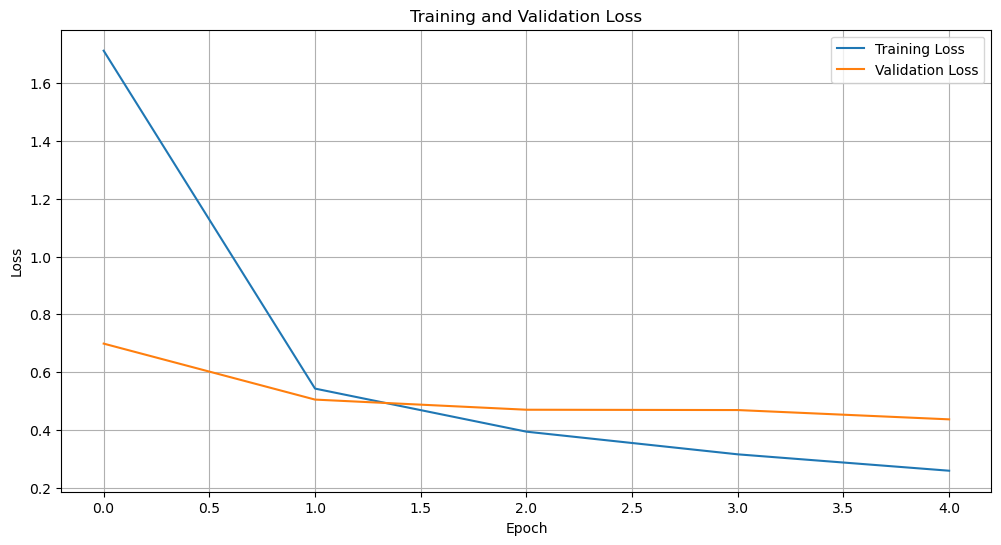

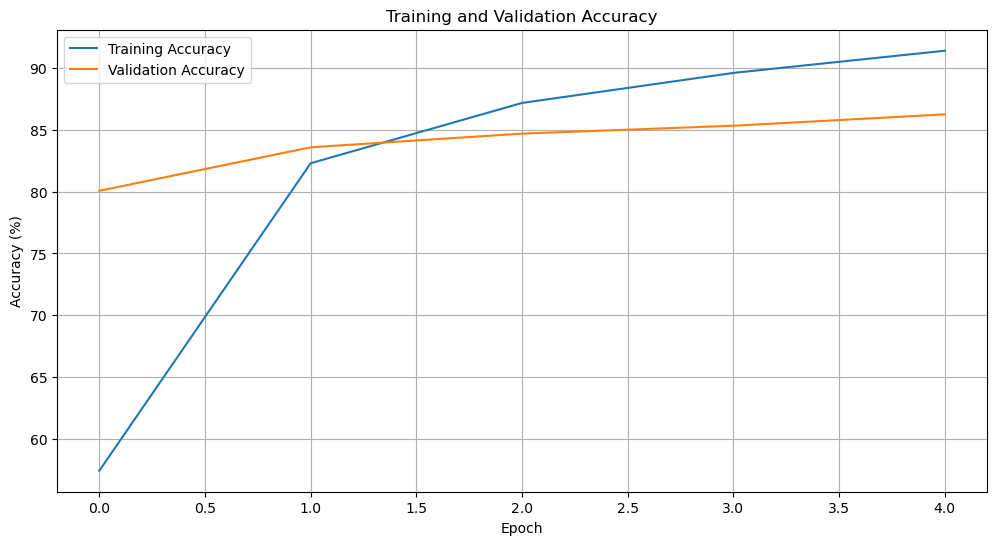

In [18]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model_top5(model, criterion, dataloader):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    top5_correct = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Calculate Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.unsqueeze(1)).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_loss = loss / len(dataloader)
    accuracy = 100 * correct / total
    top5_accuracy = 100 * top5_correct / total
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    return avg_loss, accuracy, top5_accuracy, cm


In [20]:
# Test the model and get Top-5 Accuracy and confusion matrix
test_loss, test_accuracy, top5_accuracy, cm = evaluate_model_top5(model, criterion, test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Top-5 Accuracy: {top5_accuracy:.2f}%')


Test Loss: 0.4466, Test Accuracy: 86.23%, Top-5 Accuracy: 98.90%


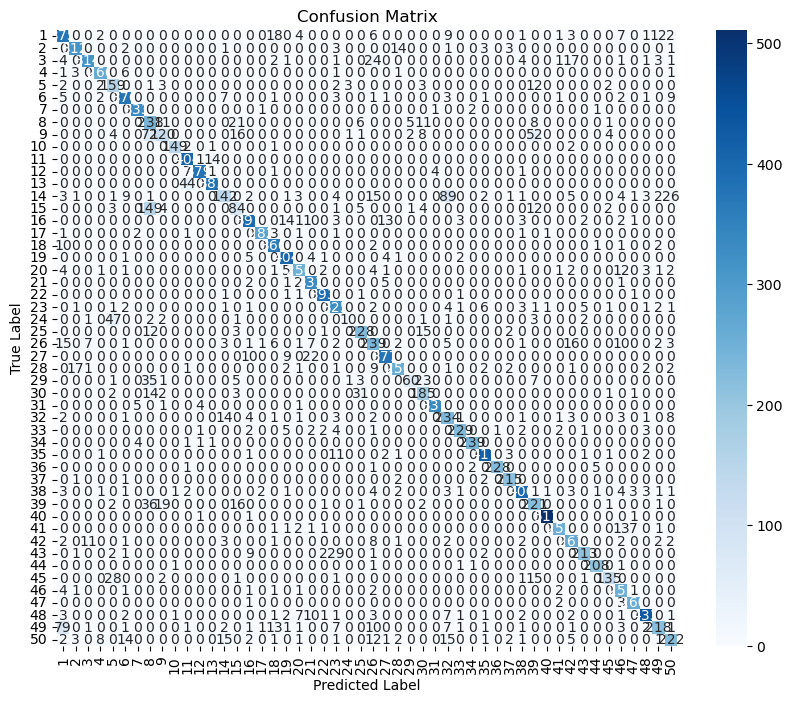

In [23]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1,51), yticklabels=range(1,51))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
